# Spike Gadgets Ephys and Video Syncing

In [65]:
import re
import sys
from collections import defaultdict
import random
from random import randrange
import glob
import warnings
import os

In [2]:
import numpy as np
import pandas as pd
import cv2
from IPython.display import Video
import matplotlib.pyplot as plt

In [3]:
# setting path
sys.path.append('../../src')

In [4]:
import trodes.read_exported

In [5]:
%matplotlib inline

In [82]:
np.random.seed(seed=42)

# Part 0: Index of all the column names

raw directory
- raw_group0.dat
    - voltage_value: Array with voltage measurement for each channel at each timestamp
- timestamps.dat
    - voltage_time_stamp: The time stamp of each voltage measurement

parent directory
- 1.videoTimeStamps.cameraHWSync
    - frame_number: Calculated by getting the index of each video time stamp tuple 
    - PosTimestamp: The time stamp of each video frame
    - HWframeCount: Unknown value. Starts at 30742 and increases by 1 for each tuple  
    - HWTimestamp: Unknown value. All zeroes
    - video_time: Calculated by dividing the frame number by the fps(frames per second) 
    - video_seconds: video_time, but rounded to seconds  	
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_PosTimestamp 	
        - filledHWframeCount 	
        - filled_frame_number 	
        - filled_video_time 	
        - filled_video_seconds 	

DIO directory
- dio_ECU_Din1.dat
    - time: The time stamp the corresponds to the DIN input
    - state: Binary state of whether there is input from DIN or not 	
    - trial_number: Calculated by adding 1 to every time there is a DIN input
    - These are filled in versions of the above collumns with the value from the most recent previous cell
        - filled_state 	
        - filled_trial_number

ss_output directory (Spike sorting with Spike interface)
- firings.npz
    - unit_id: All the units that had a spike train for the given timestamp 	
    - number_of_units: Calculated by counting the number of units that had a spike train

# Part 1: Inputting Data

## Name of protocol for naming

- This name will be used to name files and title plots. Please change if you are using a different protocol or adding more details
    - **NOTE**: This should be changed based on the name the protocol

In [6]:
protocol_name = "rc_extention"

## Getting the file name of the raw data

- Default input folder and keyword to search the files for 
    - **NOTE**: This should not be changed unless there is a consistent change with the file naming convention

In [7]:
input_folder = "./data"

In [8]:
# Accomodates for both capitalization of the file names
raw_data_file_keyword = '*[mM]edpc*'

- Asking the user what the path to the recording files are, with the option of using wildcards

- Make this cell into non-code block if you are using the same file path for multiple runs

In [10]:
raw_data_glob_pattern = "../../data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1"

- By default, this will search for files that are in the `./data` folder (in the folder that this notebook is in) that have key word you specified in the file name

In [11]:
# Using the user inputted path/pattern
if raw_data_glob_pattern.strip():
    # Getting a list of all matching files
    raw_data_files_list = glob.glob(raw_data_glob_pattern.strip())
    # Checking if there were any files that matched
    if raw_data_files_list:
        raw_data_file_path = raw_data_files_list[0]
    else:
        raise ValueError("No files were found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))

# Using the default pattern
else:
    # Searching for matching files with recursion
    if glob.glob(os.path.join(input_folder + "**", raw_data_file_keyword)):
        raw_data_glob_pattern = os.path.join(input_folder + "**", raw_data_file_keyword)
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    # Searching for matching files only in the specified folder
    elif glob.glob(os.path.join(input_folder, raw_data_file_keyword)):
        raw_data_glob_pattern = glob.glob(os.path.join(input_folder, raw_data_file_keyword))
        # Getting a list of all matching files
        raw_data_files_list = glob.glob(raw_data_glob_pattern)
    else:
        raise ValueError("No files were found in {} that had the keyword {} in it".format(input_folder, raw_data_file_keyword))


- Checking to see if only one file is specified

In [12]:
if len(raw_data_files_list) >= 2:
    raise ValueError("More than one file was found with the path/pattern of {}. Please rerun the previous cell with the correct path".format(raw_data_glob_pattern))
else:
    # Using the first(and only file) as the file path
    raw_data_file_path = raw_data_files_list[0]

In [13]:
raw_data_file_path

'../../data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1'

## Extracting the data and the metadata from the Recording folder

- Creating a dictionary that has the directory as the key and a dictionary that has the file name as the key and the 

In [14]:
file_to_data = trodes.read_exported.get_all_trodes_data_from_directory(raw_data_file_path)

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_03_rc_pose_analysis/../../src/trodes/read_exported.py:70: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return np.dtype(typearr)


file prefix: LFP_nt25ch1.dat
directory prefix: LFP
file prefix: LFP_nt4ch1.dat
directory prefix: LFP
file prefix: LFP_nt5ch1.dat
directory prefix: LFP
file prefix: LFP_nt32ch1.dat
directory prefix: LFP
file prefix: LFP_nt20ch1.dat
directory prefix: LFP
file prefix: LFP_nt1ch1.dat
directory prefix: LFP
file prefix: LFP_nt22ch1.dat
directory prefix: LFP
file prefix: LFP_nt24ch1.dat
directory prefix: LFP
file prefix: LFP_nt13ch1.dat
directory prefix: LFP
file prefix: LFP_nt18ch1.dat
directory prefix: LFP
file prefix: LFP_nt2ch1.dat
directory prefix: LFP
file prefix: LFP_nt10ch1.dat
directory prefix: LFP
file prefix: LFP_nt12ch1.dat
directory prefix: LFP
file prefix: timestamps.dat
directory prefix: LFP
file prefix: LFP_nt27ch1.dat
directory prefix: LFP
file prefix: LFP_nt19ch1.dat
directory prefix: LFP
file prefix: LFP_nt28ch1.dat
directory prefix: LFP
file prefix: LFP_nt14ch1.dat
directory prefix: LFP
file prefix: LFP_nt11ch1.dat
directory prefix: LFP
file prefix: LFP_nt6ch1.dat
director

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_03_rc_pose_analysis/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_subject_6_1_top_1_base_2_merged.kilosort/20221125_144832_omission_subject_6_1_top_1_base_2_merged.group0.dat
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_03_rc_pose_analysis/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.mp4
  warnings.warn("Can not process {}".forma

file prefix: timestamps.dat
directory prefix: time
file prefix: spikes_nt22.dat
directory prefix: spikes
file prefix: spikes_nt10.dat
directory prefix: spikes
file prefix: spikes_nt20.dat
directory prefix: spikes
file prefix: spikes_nt23.dat
directory prefix: spikes
file prefix: spikes_nt9.dat
directory prefix: spikes
file prefix: spikes_nt2.dat
directory prefix: spikes
file prefix: spikes_nt8.dat
directory prefix: spikes
file prefix: spikes_nt7.dat
directory prefix: spikes
file prefix: spikes_nt25.dat
directory prefix: spikes
file prefix: spikes_nt14.dat
directory prefix: spikes
file prefix: spikes_nt5.dat
directory prefix: spikes
file prefix: spikes_nt24.dat
directory prefix: spikes
file prefix: spikes_nt19.dat
directory prefix: spikes
file prefix: spikes_nt4.dat
directory prefix: spikes
file prefix: spikes_nt11.dat
directory prefix: spikes
file prefix: spikes_nt28.dat
directory prefix: spikes
file prefix: spikes_nt17.dat
directory prefix: spikes
file prefix: spikes_nt3.dat
directory

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_03_rc_pose_analysis/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_subject_6_1_top_1_base_2_merged.mountainsort/20221125_144832_omission_subject_6_1_top_1_base_2_merged.timestamps.mda
  warnings.warn("Can not process {}".format(absolute_file_path))
/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_03_rc_pose_analysis/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_subject_6_1_top_1_base_2_merged.mountainsort/20221125_144832_omission_subjec

file prefix: raw_group0.dat
directory prefix: raw
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: 1.videoTimeStamps.cameraHWSync
directory prefix: .
file prefix: spikeband_nt13ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt24ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt20ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt30ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt19ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt31ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt9ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt2ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt10ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt29ch1.dat
directory prefix: spikeband
file prefix: timestamps.dat
directory prefix: spikeband
file prefix: spikeband_nt5ch1.dat
directory prefix: spikeband
file prefix: spikeband_nt1ch1.dat
directory prefix: spikeband
file prefix: s

/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/results/2023_05_03_rc_pose_analysis/../../src/trodes/read_exported.py:138: UserWarning: Can not process /nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_subject_6_1_top_1_base_2_merged.timestampoffset/20221125_144832_omission_subject_6_1_top_1_base_2_merged.timestampoffset.txt
  warnings.warn("Can not process {}".format(absolute_file_path))


- All the folders that were extracted from

In [15]:
file_to_data.keys()

dict_keys(['20221125_144832_omission_subject_6_1_top_1_base_2_merged.LFP', 'LFP', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.kilosort', 'kilosort', '.', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.time', 'time', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.spikes', 'spikes', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.analog', 'analog', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.mountainsort', 'mountainsort', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.raw', 'raw', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.spikeband', 'spikeband', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.stimulation', 'stimulation', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.DIO', 'DIO', '20221125_144832_omission_subject_6_1_top_1_base_2_merged.timestampoffset'])

In [16]:
file_to_data["."]

{'1.videoTimeStamps.cameraHWSync': {'clock rate': '30000',
  'fields': '<PosTimestamp uint32><HWframeCount uint32><HWTimestamp uint64>',
  'data': array([( 3680868, 0, 0), ( 3682254, 0, 0), ( 3682254, 0, 0), ...,
         (29060297, 0, 0), (29061683, 0, 0), (29061683, 0, 0)],
        dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')]),
  'absolute_file_path': '/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.videoTimeStamps.cameraHWSync'}}

In [17]:
file_to_data["spikeband"]

{'spikeband_nt13ch1.dat': {'description': 'Spike band continuous data for one channel',
  'byte_order': 'little endian',
  'original_file': '20221125_144832_omission_subject_6_1_top_1_base_2_merged.rec',
  'clockrate': '20000',
  'trodes_version': '2.3.2',
  'compile_date': 'Apr 12 2022',
  'compile_time': '15:21:02',
  'qt_version': '6.2.2',
  'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
  'controller_firmware': '3.17',
  'headstage_firmware': '2.2',
  'controller_serialnum': '00104 00176',
  'headstage_serialnum': '01601 00129',
  'autosettle': '0',
  'smartref': '0',
  'gyro': '0',
  'accelerometer': '0',
  'magnetometer': '1',
  'time_offset': '0',
  'system_time_at_creation': '1669405743330',
  'timestamp_at_creation': '3643450',
  'first_timestamp': '3680870',
  'ntrode_id': '13',
  'num_channels': '1',
  'voltage_scaling': '0.195',
  'reference': 'off',
  'spike_invert': 'yes',
  'fields': '<voltage int16>',
  'data': array([(-383,), (-503,), (-540,), ..., ( -23,), (-183,), 

- Looking over all the extracted data

In [18]:
for key, value in file_to_data.items():
    print("Directory: {}".format(key))
    for file_name, trodes_dict in value.items():
        print("\tFile Name: {}".format(file_name))
        for data_type, data_value in trodes_dict.items():
            print("\n \t \t Trodes Data Type: {}".format(data_type))
            print("\t \t Python Type: {}".format(type(data_value)))
            print("\t \t Data Value: {}".format(data_value))

Directory: 20221125_144832_omission_subject_6_1_top_1_base_2_merged.LFP
	File Name: LFP_nt25ch1.dat

 	 	 Trodes Data Type: description
	 	 Python Type: <class 'str'>
	 	 Data Value: LFP data for one channel

 	 	 Trodes Data Type: byte_order
	 	 Python Type: <class 'str'>
	 	 Data Value: little endian

 	 	 Trodes Data Type: original_file
	 	 Python Type: <class 'str'>
	 	 Data Value: 20221125_144832_omission_subject_6_1_top_1_base_2_merged.rec

 	 	 Trodes Data Type: clockrate
	 	 Python Type: <class 'str'>
	 	 Data Value: 20000

 	 	 Trodes Data Type: trodes_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 2.3.2

 	 	 Trodes Data Type: compile_date
	 	 Python Type: <class 'str'>
	 	 Data Value: Apr 12 2022

 	 	 Trodes Data Type: compile_time
	 	 Python Type: <class 'str'>
	 	 Data Value: 15:21:02

 	 	 Trodes Data Type: qt_version
	 	 Python Type: <class 'str'>
	 	 Data Value: 6.2.2

 	 	 Trodes Data Type: commit_tag
	 	 Python Type: <class 'str'>
	 	 Data Value: heads/Releas

# Part 2: Looking over the data

## Looking over the ephys recording

- Getting the name of the ephys recording directory

In [36]:
raw_directory_dict = file_to_data["raw"]

- Getting the name of the files in the ephys recording directory

In [37]:
raw_directory_dict.keys()

dict_keys(['timestamps.dat', 'group0.coordinates.dat', 'raw_group0.dat'])

In [38]:
raw_recording_fields_text = raw_directory_dict["raw_group0.dat"]

In [39]:
raw_recording_fields_text

{'description': 'Raw (unfiltered) data for one sorting group',
 'byte_order': 'little endian',
 'original_file': '20221125_144832_omission_subject_6_1_top_1_base_2_merged.rec',
 'clockrate': '20000',
 'trodes_version': '2.3.2',
 'compile_date': 'Apr 12 2022',
 'compile_time': '15:21:02',
 'qt_version': '6.2.2',
 'commit_tag': 'heads/Release_2.3.2-0-g15f12712',
 'controller_firmware': '3.17',
 'headstage_firmware': '2.2',
 'controller_serialnum': '00104 00176',
 'headstage_serialnum': '01601 00129',
 'autosettle': '0',
 'smartref': '0',
 'gyro': '0',
 'accelerometer': '0',
 'magnetometer': '1',
 'time_offset': '0',
 'system_time_at_creation': '1669405743330',
 'timestamp_at_creation': '3643450',
 'first_timestamp': '3680870',
 'sorting_group': '0',
 'num_channels': '32',
 'voltage_scaling': '0.195',
 'fields': '<voltage 32*int16>',
 'data': array([([ 430,  537,  449,  459,  432,  454,  508,  526,  528,  267,  425,  246,  438,  530, 1101,  213,  466,  623,  240,  483,  489,  746,  525,  

- Array of Voltages for each channel

In [40]:
voltage_value_array = raw_recording_fields_text["data"]

In [41]:
voltage_value_array.shape

(25382200,)

In [53]:
voltage_value_array[0]

([ 430,  537,  449,  459,  432,  454,  508,  526,  528,  267,  425,  246,  438,  530, 1101,  213,  466,  623,  240,  483,  489,  746,  525,  591,  492,  559,  652,  501,  642,  720,  558,  715],)

In [55]:
len(voltage_value_array[0][0])

32

In [42]:
voltage_value_array[:5]

array([([ 430,  537,  449,  459,  432,  454,  508,  526,  528,  267,  425,  246,  438,  530, 1101,  213,  466,  623,  240,  483,  489,  746,  525,  591,  492,  559,  652,  501,  642,  720,  558,  715],),
       ([ 620,  717,  649,  727,  587,  645,  682,  737,  608,  564,  620,  381,  584,  693, 1196,  369,  587,  788,  375,  558,  644,  780,  717,  696,  616,  756,  640,  759,  747,  626,  541,  783],),
       ([ 650,  847,  693,  830,  692,  784,  862,  919,  800,  697,  750,  587,  692,  708, 1292,  463,  657,  885,  544,  725,  868,  832,  842,  891,  746,  826,  668,  754,  690,  763,  592,  854],),
       ([ 651,  921,  757,  783,  792,  752,  832,  918,  757,  788,  738,  561,  640,  854, 1374,  516,  670,  888,  765,  732,  835,  796,  826,  850,  720,  886,  757,  752,  707,  743,  747,  797],),
       ([ 669,  891,  858,  791,  824,  804,  862,  912,  829,  821,  794,  781,  757,  917, 1325,  521,  710,  879,  680,  762,  762,  896,  853,  893,  749,  906,  650,  728,  721,  

- Voltage Time Stamps

In [43]:
raw_directory_dict.keys()

dict_keys(['timestamps.dat', 'group0.coordinates.dat', 'raw_group0.dat'])

In [44]:
voltage_timestamp_array = raw_directory_dict["timestamps.dat"]["data"]

In [45]:
voltage_timestamp_array[:5]

array([(3680870,), (3680871,), (3680872,), (3680873,), (3680874,)],
      dtype=[('time', '<u4')])

In [46]:
voltage_timestamp_array[-5:]

array([(29063065,), (29063066,), (29063067,), (29063068,), (29063069,)],
      dtype=[('time', '<u4')])

In [47]:
voltage_timestamp_array.shape

(25382200,)

- Converting the array to integers to be able to do calculations

    - u4 and i2 explanation: https://www.geeksforgeeks.org/data-type-object-dtype-numpy-python/

In [48]:
voltage_timestamp_array = voltage_timestamp_array.astype(int)

In [49]:
voltage_timestamp_array[:5]

array([3680870, 3680871, 3680872, 3680873, 3680874])

In [50]:
voltage_timestamp_array[-5:]

array([29063065, 29063066, 29063067, 29063068, 29063069])

In [51]:
voltage_timestamp_array.shape

(25382200,)

## Looking over the video files

In [56]:
parent_directory_dict = file_to_data["."]

In [57]:
video_time_stamp_dict = parent_directory_dict["1.videoTimeStamps.cameraHWSync"]

In [58]:
video_time_stamp_dict

{'clock rate': '30000',
 'fields': '<PosTimestamp uint32><HWframeCount uint32><HWTimestamp uint64>',
 'data': array([( 3680868, 0, 0), ( 3682254, 0, 0), ( 3682254, 0, 0), ...,
        (29060297, 0, 0), (29061683, 0, 0), (29061683, 0, 0)],
       dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')]),
 'absolute_file_path': '/nancy/projects/reward_competition_ephys_analysis_with_omission_and_divider_controls/data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.videoTimeStamps.cameraHWSync'}

In [59]:
video_time_stamp_dict["data"]

array([( 3680868, 0, 0), ( 3682254, 0, 0), ( 3682254, 0, 0), ...,
       (29060297, 0, 0), (29061683, 0, 0), (29061683, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [60]:
video_time_stamp_dict["data"][:5]

array([(3680868, 0, 0), (3682254, 0, 0), (3682254, 0, 0), (3683640, 0, 0),
       (3685026, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [61]:
video_time_stamp_dict["data"][-5:]

array([(29057526, 0, 0), (29058912, 0, 0), (29060297, 0, 0),
       (29061683, 0, 0), (29061683, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [62]:
video_time_stamp_dict["data"].shape

(25335,)

## Video time to Video frame

### Reading in video

In [63]:
raw_data_file_path

'../../data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1'

In [66]:
video_file_list = glob.glob(os.path.join(raw_data_file_path, "*.mp4"))

In [67]:
video_file_list

['../../data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.mp4',
 '../../data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.fixed.mp4']

In [68]:
video_file_path = "../../data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.fixed.mp4"

In [69]:
# read video from file
cap = cv2.VideoCapture(video_file_path)

- Getting the number of frames per second

In [70]:
fps = cap.get(cv2.CAP_PROP_FPS)

In [71]:
fps

14.0

- Total number of frames

In [72]:
total_frame_count = cap.get(cv2.CAP_PROP_FRAME_COUNT)

In [73]:
total_frame_count


25336.0

- Calculating the length of the video by dividing the total number of frames by the fps

In [74]:
video_length = total_frame_count / fps

In [75]:
video_length

1809.7142857142858

In [79]:
random_video_frame

array([12502.])

# Part 3: Converting everything into timestamps

## Voltage to timestamp

- Use the matching index to convert between the voltage time stamp and the recording

In [83]:
voltage_index = 0

In [71]:
random_voltage_index

array([12578648])

In [84]:
voltage_value_array[voltage_index]

([ 430,  537,  449,  459,  432,  454,  508,  526,  528,  267,  425,  246,  438,  530, 1101,  213,  466,  623,  240,  483,  489,  746,  525,  591,  492,  559,  652,  501,  642,  720,  558,  715],)

- Getting the associated timestamp of the ephys recording

In [91]:
voltage_timestamp_array[:5]

array([3680870, 3680871, 3680872, 3680873, 3680874])

In [92]:
voltage_timestamp_array[-5:]

array([29063065, 29063066, 29063067, 29063068, 29063069])

In [88]:
voltage_time_stamp = voltage_timestamp_array[voltage_index]

In [89]:
voltage_time_stamp

3680870

In [93]:
raise ValueError()

ValueError: 

## Video frame to timestamp

- Getting the time stamps of the video frames
    - Each frame would correspond to each timestamp. Because the sample rate of videos is smaller than ephys recording, the number of video time stamps will be less than that of ephys recordings.

In [75]:
video_time_stamp_array = np.array(video_time_stamp_dict["data"])

In [76]:
video_time_stamp_array

array([( 3680868, 0, 0), ( 3682254, 0, 0), ( 3682254, 0, 0), ...,
       (29060297, 0, 0), (29061683, 0, 0), (29061683, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [77]:
video_time_stamp_array.shape

(25335,)

In [78]:
random_frame = np.random.choice(video_time_stamp_array.shape[0], 1, replace=False)  

In [79]:
random_frame

array([869])

- Getting only the first number in each tuple

In [80]:
pos_timestamp_array = np.array([x[0] for x in video_time_stamp_array]) 

In [81]:
pos_timestamp_array

array([ 3680868,  3682254,  3682254, ..., 29060297, 29061683, 29061683],
      dtype=uint32)

- Converting to integer to do calculations

In [82]:
pos_timestamp_array = pos_timestamp_array.astype(int)

In [83]:
pos_timestamp_array[random_frame]

array([4551194])

- And converting it back to timestamp

In [80]:
pos_timestamp_array[int(random_video_frame[0])]

NameError: name 'pos_timestamp_array' is not defined

In [52]:
raise ValueError("check everything before this")

ValueError: check everything before this

# Part 4: Converting from timestamps back to everything

In [137]:
def timestamp_to_index(current_ts, ts_array):
    """
    """
    return np.argwhere(ts_array >= current_ts)[0][0]

## Time stamp to Voltage Value

In [138]:
random_voltage_time_stamp

array([16259518])

In [89]:
voltage_timestamp_array

array([ 3680870,  3680871,  3680872, ..., 29063067, 29063068, 29063069])

- Getting the index of the closest timestamp 

In [90]:
random_voltage_index = timestamp_to_index(current_ts=random_voltage_time_stamp, ts_array=voltage_timestamp_array)

In [91]:
random_voltage_index

12578648

- Checking if it matches to the original timestamp
    - Should be the same, because the sampling rate of the timestamps are based on the ephys recording

In [92]:
voltage_timestamp_array[random_voltage_index]

16259518

- Getting the voltage value based on the index

In [93]:
voltage_value_array[random_voltage_index]

([-911, -745, -866, -835, -681, -770, -845, -752, -692, -818, -868, -681, -611, -304, -289, -975, -620, -537, -681, -739, -649, -729, -623, -721, -730, -759, -798, -927, -915, -916, -901, -901],)

## Time Stamp to Video Frame

In [94]:
video_time_stamp_array

array([( 3680868, 0, 0), ( 3682254, 0, 0), ( 3682254, 0, 0), ...,
       (29060297, 0, 0), (29061683, 0, 0), (29061683, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [95]:
pos_timestamp_array

array([ 3680868,  3682254,  3682254, ..., 29060297, 29061683, 29061683])

- Getting the index of the closest timestamp. The index corresponds to the video's frame number

In [96]:
random_video_frame = timestamp_to_index(current_ts=random_voltage_time_stamp, ts_array=pos_timestamp_array)

In [97]:
random_video_frame

12556

In [98]:
pos_timestamp_array[random_video_frame]

16260406

## Video Frame to Video Time

In [142]:
random_video_frame / fps

array([1735.])

# Part 4: Syncing everything based on timestamps

# Syncing with MED-PC

In [143]:
DIO_directory_name = trodes.read_exported.get_key_with_substring(file_to_data, substring="DIO")

In [144]:
DIO_directory_name

'DIO'

In [145]:
DIO_directory_dict = file_to_data[DIO_directory_name]

In [146]:
DIO_directory_dict.keys()

dict_keys(['dio_ECU_Dout20.dat', 'dio_ECU_Din6.dat', 'dio_ECU_Dout30.dat', 'dio_ECU_Dout28.dat', 'dio_ECU_Din13.dat', 'dio_ECU_Din21.dat', 'dio_ECU_Din25.dat', 'dio_ECU_Dout2.dat', 'dio_Controller_Din7.dat', 'dio_ECU_Din3.dat', 'dio_ECU_Dout7.dat', 'dio_ECU_Din32.dat', 'dio_ECU_Din28.dat', 'dio_ECU_Din12.dat', 'dio_ECU_Dout21.dat', 'dio_Controller_Din8.dat', 'dio_Controller_Din3.dat', 'dio_ECU_Dout26.dat', 'dio_ECU_Din27.dat', 'dio_ECU_Dout5.dat', 'dio_ECU_Din18.dat', 'dio_ECU_Din16.dat', 'dio_ECU_Din8.dat', 'dio_ECU_Dout9.dat', 'dio_Controller_Din2.dat', 'dio_ECU_Din15.dat', 'dio_ECU_Dout29.dat', 'dio_ECU_Din7.dat', 'dio_ECU_Dout14.dat', 'dio_ECU_Dout10.dat', 'dio_ECU_Dout27.dat', 'dio_ECU_Dout15.dat', 'dio_ECU_Dout3.dat', 'dio_ECU_Din23.dat', 'dio_ECU_Dout16.dat', 'dio_ECU_Din10.dat', 'dio_ECU_Dout23.dat', 'dio_ECU_Din4.dat', 'dio_Controller_Din5.dat', 'dio_ECU_Din20.dat', 'dio_ECU_Dout17.dat', 'dio_ECU_Dout32.dat', 'dio_ECU_Din24.dat', 'dio_Controller_Din1.dat', 'dio_ECU_Din30.dat',

In [147]:
DIN_file_name = trodes.read_exported.get_key_with_substring(DIO_directory_dict, substring="ECU_Din1.dat", return_first=True)

In [148]:
DIN_file_name

'dio_ECU_Din1.dat'

In [149]:
DIN_state_array = DIO_directory_dict[DIN_file_name]["data"]

In [150]:
DIN_state_array

array([( 3680870, 1), ( 3825268, 0), ( 5025667, 1), ( 5225666, 0),
       ( 6625665, 1), ( 6825665, 0), ( 8425664, 1), ( 8625663, 0),
       (10025660, 1), (10225662, 0), (11525660, 1), (11725660, 0),
       (13525658, 1), (13725661, 0), (15425657, 1), (15625656, 0),
       (17225655, 1), (17425651, 0), (18825652, 1), (19025653, 0),
       (20625651, 1), (20825651, 0), (22625649, 1), (22825649, 0),
       (24425647, 1), (24625644, 0), (26825644, 1), (27025644, 0),
       (28625643, 1), (28825643, 0), (29025242, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

(array([15.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 16.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

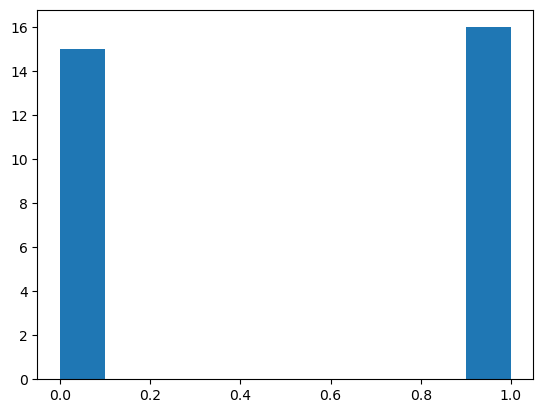

In [151]:
plt.hist([tup[1] for tup in DIN_state_array])

Text(0.5, 1.0, 'Din State Change against Timestamps')

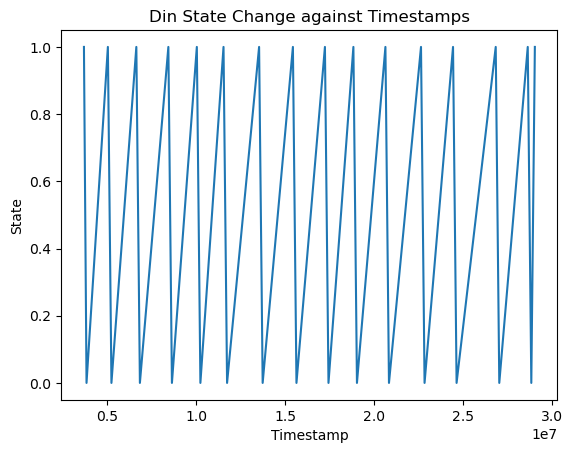

In [152]:
plt.plot([tup[0] for tup in DIN_state_array], [tup[1] for tup in DIN_state_array])
plt.xlabel("Timestamp")
plt.ylabel("State")
plt.title("Din State Change against Timestamps")

# From DIN to Video

- State 1 is when the MED-PC signal is being recieved. And 0 is when it is turned off. So we will get the timestamp of when it is first 1.

In [153]:
DIN_state_array

array([( 3680870, 1), ( 3825268, 0), ( 5025667, 1), ( 5225666, 0),
       ( 6625665, 1), ( 6825665, 0), ( 8425664, 1), ( 8625663, 0),
       (10025660, 1), (10225662, 0), (11525660, 1), (11725660, 0),
       (13525658, 1), (13725661, 0), (15425657, 1), (15625656, 0),
       (17225655, 1), (17425651, 0), (18825652, 1), (19025653, 0),
       (20625651, 1), (20825651, 0), (22625649, 1), (22825649, 0),
       (24425647, 1), (24625644, 0), (26825644, 1), (27025644, 0),
       (28625643, 1), (28825643, 0), (29025242, 1)],
      dtype=[('time', '<u4'), ('state', 'u1')])

In [154]:
DIN_time_stamp = DIN_state_array[5][0]

In [155]:
DIN_time_stamp

6825665

- Array of the time stamp of all the frames

In [156]:
pos_timestamp_array

array([ 3680868,  3682254,  3682254, ..., 29060297, 29061683, 29061683])

- Getting the first video time stamp that is greater than the voltage time stamp

In [157]:
current_video_frame = timestamp_to_index(current_ts=DIN_time_stamp, ts_array=pos_timestamp_array)

In [158]:
current_video_frame

3140

## Getting the specific frame

In [159]:
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print('Frame count:', frame_count)

Frame count: 25334


- Original frame number(before light turns on)

In [160]:
corrected_video_frame = current_video_frame

- Corrected frame number(that has the light on)

In [161]:
corrected_video_frame = current_video_frame + 2

In [162]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


True

In [163]:
_, frame = cap.read()

In [164]:
video_file_path

'../../data/good/20221125_144832_omission_subject_6_1_and_6_2.rec/omission_6_1/20221125_144832_omission_and_competition_subejct_6_1_and_6_2.1.mp4'

In [165]:
output_directory = "./proc"

In [166]:
output_directory

'./proc'

In [167]:
os.makedirs(output_directory, exist_ok=True)

NameError: name 'os' is not defined

In [168]:
video_file_basename = os.path.basename(video_file_path)

NameError: name 'os' is not defined

In [169]:
video_file_root = os.path.splitext(video_file_basename)[0]

NameError: name 'os' is not defined

In [170]:
video_file_root

NameError: name 'video_file_root' is not defined

In [111]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

True

- Where this video time stamp is(within the list of video time stamps), would be the frame number that corresponds to the ephys recording instance

In [112]:
current_video_seconds = corrected_video_frame / fps

In [113]:
current_video_seconds

303.1917665679889

In [114]:
print("MED-PC signal is at {}:{}".format(int(current_video_seconds // 60), int(current_video_seconds % 60)))

MED-PC signal is at 5:3


# Syncing up the timestamps using Pandas

## Adding the Voltage as columns

In [171]:
voltage_timestamp_array[:5]

array([3680870, 3680871, 3680872, 3680873, 3680874])

In [172]:
voltage_timestamp_array.shape

(25382200,)

In [173]:
voltage_value_array[:5]

array([([ 430,  537,  449,  459,  432,  454,  508,  526,  528,  267,  425,  246,  438,  530, 1101,  213,  466,  623,  240,  483,  489,  746,  525,  591,  492,  559,  652,  501,  642,  720,  558,  715],),
       ([ 620,  717,  649,  727,  587,  645,  682,  737,  608,  564,  620,  381,  584,  693, 1196,  369,  587,  788,  375,  558,  644,  780,  717,  696,  616,  756,  640,  759,  747,  626,  541,  783],),
       ([ 650,  847,  693,  830,  692,  784,  862,  919,  800,  697,  750,  587,  692,  708, 1292,  463,  657,  885,  544,  725,  868,  832,  842,  891,  746,  826,  668,  754,  690,  763,  592,  854],),
       ([ 651,  921,  757,  783,  792,  752,  832,  918,  757,  788,  738,  561,  640,  854, 1374,  516,  670,  888,  765,  732,  835,  796,  826,  850,  720,  886,  757,  752,  707,  743,  747,  797],),
       ([ 669,  891,  858,  791,  824,  804,  862,  912,  829,  821,  794,  781,  757,  917, 1325,  521,  710,  879,  680,  762,  762,  896,  853,  893,  749,  906,  650,  728,  721,  

In [174]:
voltage_value_array.shape

(25382200,)

- Adding the voltage timestamps

In [175]:
ephys_dataframe = pd.DataFrame(voltage_timestamp_array, columns=["voltage_time_stamp"])

In [176]:
ephys_dataframe.head()

,voltage_time_stamp
0,3680870
1,3680871
2,3680872
3,3680873
4,3680874


- Adding the voltage value

In [177]:
ephys_dataframe["voltage_value"] = voltage_value_array.tolist()

In [178]:
ephys_dataframe.head()

,voltage_time_stamp,voltage_value
0,3680870,"([430, 537, 449, 459, 432, 454, 508, 526, 528,..."
1,3680871,"([620, 717, 649, 727, 587, 645, 682, 737, 608,..."
2,3680872,"([650, 847, 693, 830, 692, 784, 862, 919, 800,..."
3,3680873,"([651, 921, 757, 783, 792, 752, 832, 918, 757,..."
4,3680874,"([669, 891, 858, 791, 824, 804, 862, 912, 829,..."


## Adding the video data as columns

- Creating a seperate dataframe for video data first

In [179]:
video_time_stamp_dict["data"][:5]

array([(3680868, 0, 0), (3682254, 0, 0), (3682254, 0, 0), (3683640, 0, 0),
       (3685026, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [180]:
video_time_stamp_dict["data"][-5:]

array([(29057526, 0, 0), (29058912, 0, 0), (29060297, 0, 0),
       (29061683, 0, 0), (29061683, 0, 0)],
      dtype=[('PosTimestamp', '<u4'), ('HWframeCount', '<u4'), ('HWTimestamp', '<u8')])

In [181]:
video_dataframe = pd.DataFrame(video_time_stamp_dict["data"])

In [182]:
video_dataframe.head()

,PosTimestamp,HWframeCount,HWTimestamp
0,3680868,0,0
1,3682254,0,0
2,3682254,0,0
3,3683640,0,0
4,3685026,0,0


- Adding the frames which would just be the number in the list that the timestamps belongs to

In [183]:
video_dataframe.insert(0, 'frame_number', range(1, 1 + len(video_dataframe)))

- Calculating the time within the video by dividing the frame by the fps

In [184]:
video_dataframe["video_time"] = video_dataframe["frame_number"] / fps

In [185]:
video_dataframe["video_seconds"] = video_dataframe["video_time"].astype(int)

In [186]:
video_dataframe

,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds
0,1,3680868,0,0,0.071425,0
1,2,3682254,0,0,0.142851,0
2,3,3682254,0,0,0.214276,0
3,4,3683640,0,0,0.285702,0
4,5,3685026,0,0,0.357127,0
...,...,...,...,...,...,...
25330,25331,29057526,0,0,1809.278479,1809
25331,25332,29058912,0,0,1809.349905,1809
25332,25333,29060297,0,0,1809.421330,1809
25333,25334,29061683,0,0,1809.492756,1809


## Combining the ephys and video dataframe into one

In [187]:
ephy_and_video_dataframe = pd.merge(ephys_dataframe, video_dataframe, left_on='voltage_time_stamp', right_on='PosTimestamp', how="left")

In [188]:
ephy_and_video_dataframe

,voltage_time_stamp,voltage_value,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds
0,3680870,"([430, 537, 449, 459, 432, 454, 508, 526, 528,...",NaN,NaN,NaN,NaN,NaN,NaN
1,3680871,"([620, 717, 649, 727, 587, 645, 682, 737, 608,...",NaN,NaN,NaN,NaN,NaN,NaN
2,3680872,"([650, 847, 693, 830, 692, 784, 862, 919, 800,...",NaN,NaN,NaN,NaN,NaN,NaN
3,3680873,"([651, 921, 757, 783, 792, 752, 832, 918, 757,...",NaN,NaN,NaN,NaN,NaN,NaN
4,3680874,"([669, 891, 858, 791, 824, 804, 862, 912, 829,...",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
25388554,29063065,"([-406, -298, -271, -522, -569, -116, -464, -3...",NaN,NaN,NaN,NaN,NaN,NaN
25388555,29063066,"([-390, -399, -341, -521, -477, -93, -403, -40...",NaN,NaN,NaN,NaN,NaN,NaN
25388556,29063067,"([-413, -336, -434, -540, -491, -85, -348, -38...",NaN,NaN,NaN,NaN,NaN,NaN
25388557,29063068,"([-452, -358, -395, -563, -387, -234, -644, -4...",NaN,NaN,NaN,NaN,NaN,NaN


In [189]:
ephy_and_video_dataframe.columns

Index(['voltage_time_stamp', 'voltage_value', 'frame_number', 'PosTimestamp',
       'HWframeCount', 'HWTimestamp', 'video_time', 'video_seconds'],
      dtype='object')

- There are only a small number of rows that have information for the video, because the sampling rate is much smaller. 

In [190]:
ephy_and_video_dataframe.dropna(subset=["PosTimestamp"])

,voltage_time_stamp,voltage_value,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds
1384,3682254,"([-539, -393, -472, -458, -288, -448, -512, -4...",2.0,3682254.0,0.0,0.0,0.142851,0.0
1385,3682254,"([-539, -393, -472, -458, -288, -448, -512, -4...",3.0,3682254.0,0.0,0.0,0.214276,0.0
2771,3683640,"([-117, -238, -168, -64, -242, -246, -223, -21...",4.0,3683640.0,0.0,0.0,0.285702,0.0
4157,3685026,"([378, 359, 676, 699, 502, 450, 505, 453, 537,...",5.0,3685026.0,0.0,0.0,0.357127,0.0
5543,3686412,"([-99, -223, -221, -107, -44, -156, -170, -67,...",6.0,3686412.0,0.0,0.0,0.428553,0.0
...,...,...,...,...,...,...,...,...
25383014,29057526,"([-239, -33, 19, -6, -88, 154, 132, 266, 113, ...",25331.0,29057526.0,0.0,0.0,1809.278479,1809.0
25384400,29058912,"([730, 662, 796, 643, 547, 621, 726, 654, 560,...",25332.0,29058912.0,0.0,0.0,1809.349905,1809.0
25385785,29060297,"([38, -75, -84, -212, -37, -64, -250, -117, -1...",25333.0,29060297.0,0.0,0.0,1809.421330,1809.0
25387171,29061683,"([-193, -306, 63, -10, -56, -116, -136, -422, ...",25334.0,29061683.0,0.0,0.0,1809.492756,1809.0


- Filling in all the blank cells with the previous rows for the video related columns into new columns. This can be used to select for all rows that correspond to something happening within the video

In [191]:
ephy_and_video_dataframe['filled_PosTimestamp'] = ephy_and_video_dataframe['PosTimestamp'].fillna(method='ffill')
ephy_and_video_dataframe['filledHWframeCount'] = ephy_and_video_dataframe['HWframeCount'].fillna(method='ffill')
ephy_and_video_dataframe['filled_frame_number'] = ephy_and_video_dataframe['frame_number'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_time'] = ephy_and_video_dataframe['video_time'].fillna(method='ffill')
ephy_and_video_dataframe['filled_video_seconds'] = ephy_and_video_dataframe['video_seconds'].fillna(method='ffill')

In [192]:
ephy_and_video_dataframe.tail()

,voltage_time_stamp,voltage_value,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds,filled_PosTimestamp,filledHWframeCount,filled_frame_number,filled_video_time,filled_video_seconds
25388554,29063065,"([-406, -298, -271, -522, -569, -116, -464, -3...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0
25388555,29063066,"([-390, -399, -341, -521, -477, -93, -403, -40...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0
25388556,29063067,"([-413, -336, -434, -540, -491, -85, -348, -38...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0
25388557,29063068,"([-452, -358, -395, -563, -387, -234, -644, -4...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0
25388558,29063069,"([-349, -261, -411, -475, -302, -327, -526, -3...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0


## Adding the DIN info

In [193]:
DIN_dataframe = pd.DataFrame(DIN_state_array)

In [194]:
DIN_dataframe["trial_number"] = DIN_dataframe["state"].cumsum()

In [195]:
DIN_dataframe

,time,state,trial_number
0,3680870,1,1
1,3825268,0,1
2,5025667,1,2
3,5225666,0,2
4,6625665,1,3
5,6825665,0,3
6,8425664,1,4
7,8625663,0,4
8,10025660,1,5
9,10225662,0,5


In [196]:
ephy_and_video_dataframe = pd.merge(ephy_and_video_dataframe, DIN_dataframe, left_on='voltage_time_stamp', right_on='time', how="left")


In [197]:
ephy_and_video_dataframe.head()

,voltage_time_stamp,voltage_value,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds,filled_PosTimestamp,filledHWframeCount,filled_frame_number,filled_video_time,filled_video_seconds,time,state,trial_number
0,3680870,"([430, 537, 449, 459, 432, 454, 508, 526, 528,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3680870.0,1.0,1.0
1,3680871,"([620, 717, 649, 727, 587, 645, 682, 737, 608,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3680872,"([650, 847, 693, 830, 692, 784, 862, 919, 800,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3680873,"([651, 921, 757, 783, 792, 752, 832, 918, 757,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3680874,"([669, 891, 858, 791, 824, 804, 862, 912, 829,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [198]:
ephy_and_video_dataframe.dropna(subset=["time"])

,voltage_time_stamp,voltage_value,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds,filled_PosTimestamp,filledHWframeCount,filled_frame_number,filled_video_time,filled_video_seconds,time,state,trial_number
0,3680870,"([430, 537, 449, 459, 432, 454, 508, 526, 528,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3680870.0,1.0,1.0
144435,3825268,"([-13, -58, -137, 118, 130, -29, 144, 129, 12,...",NaN,NaN,NaN,NaN,NaN,NaN,3824999.0,0.0,145.0,10.356693,10.0,3825268.0,0.0,1.0
1345131,5025667,"([430, 468, 625, 566, 436, 428, 292, 486, 546,...",NaN,NaN,NaN,NaN,NaN,NaN,5025162.0,0.0,1343.0,95.924401,95.0,5025667.0,1.0,2.0
1545181,5225666,"([-554, -564, -474, -596, -542, -600, -623, -5...",NaN,NaN,NaN,NaN,NaN,NaN,5224727.0,0.0,1542.0,110.138069,110.0,5225666.0,0.0,2.0
2945523,6625665,"([619, 669, 761, 722, 692, 730, 775, 835, 792,...",NaN,NaN,NaN,NaN,NaN,NaN,6624455.0,0.0,2939.0,209.919445,209.0,6625665.0,1.0,3.0
3145574,6825665,"([254, 101, 134, 138, 177, 150, 182, 255, 147,...",NaN,NaN,NaN,NaN,NaN,NaN,6825406.0,0.0,3140.0,224.275963,224.0,6825665.0,0.0,3.0
4745966,8425664,"([469, 422, 465, 585, 535, 385, 324, 427, 426,...",NaN,NaN,NaN,NaN,NaN,NaN,8424700.0,0.0,4736.0,338.271007,338.0,8425664.0,1.0,4.0
4946017,8625663,"([-196, -153, -324, -251, -116, -176, -146, -2...",NaN,NaN,NaN,NaN,NaN,NaN,8625651.0,0.0,4937.0,352.627526,352.0,8625663.0,0.0,4.0
6346358,10025660,"([402, 175, 218, 352, 121, 415, 349, 142, 138,...",NaN,NaN,NaN,NaN,NaN,NaN,10025379.0,0.0,6334.0,452.408902,452.0,10025660.0,1.0,5.0
6546410,10225662,"([878, 733, 943, 973, 794, 979, 915, 785, 878,...",NaN,NaN,NaN,NaN,NaN,NaN,10224944.0,0.0,6533.0,466.622569,466.0,10225662.0,0.0,5.0


In [204]:
ephy_and_video_dataframe["filled_state"] = ephy_and_video_dataframe["state"].ffill()
ephy_and_video_dataframe["filled_trial_number"] = ephy_and_video_dataframe["trial_number"].ffill()

In [205]:
ephy_and_video_dataframe.head()

,voltage_time_stamp,voltage_value,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds,filled_PosTimestamp,filledHWframeCount,filled_frame_number,filled_video_time,filled_video_seconds,time,state,trial_number,filled_state,filled_trial_number
0,3680870,"([430, 537, 449, 459, 432, 454, 508, 526, 528,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3680870.0,1.0,1.0,1.0,1.0
1,3680871,"([620, 717, 649, 727, 587, 645, 682, 737, 608,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
2,3680872,"([650, 847, 693, 830, 692, 784, 862, 919, 800,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
3,3680873,"([651, 921, 757, 783, 792, 752, 832, 918, 757,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0
4,3680874,"([669, 891, 858, 791, 824, 804, 862, 912, 829,...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0


In [206]:
ephy_and_video_dataframe.tail()

,voltage_time_stamp,voltage_value,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds,filled_PosTimestamp,filledHWframeCount,filled_frame_number,filled_video_time,filled_video_seconds,time,state,trial_number,filled_state,filled_trial_number
25388554,29063065,"([-406, -298, -271, -522, -569, -116, -464, -3...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0,NaN,NaN,NaN,1.0,16.0
25388555,29063066,"([-390, -399, -341, -521, -477, -93, -403, -40...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0,NaN,NaN,NaN,1.0,16.0
25388556,29063067,"([-413, -336, -434, -540, -491, -85, -348, -38...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0,NaN,NaN,NaN,1.0,16.0
25388557,29063068,"([-452, -358, -395, -563, -387, -234, -644, -4...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0,NaN,NaN,NaN,1.0,16.0
25388558,29063069,"([-349, -261, -411, -475, -302, -327, -526, -3...",NaN,NaN,NaN,NaN,NaN,NaN,29061683.0,0.0,25335.0,1809.564181,1809.0,NaN,NaN,NaN,1.0,16.0


In [207]:
trial_1_df = ephy_and_video_dataframe[ephy_and_video_dataframe["filled_trial_number"] == 2]

In [208]:
trial_1_df.head()

,voltage_time_stamp,voltage_value,frame_number,PosTimestamp,HWframeCount,HWTimestamp,video_time,video_seconds,filled_PosTimestamp,filledHWframeCount,filled_frame_number,filled_video_time,filled_video_seconds,time,state,trial_number,filled_state,filled_trial_number
1345131,5025667,"([430, 468, 625, 566, 436, 428, 292, 486, 546,...",NaN,NaN,NaN,NaN,NaN,NaN,5025162.0,0.0,1343.0,95.924401,95.0,5025667.0,1.0,2.0,1.0,2.0
1345132,5025668,"([434, 500, 528, 441, 467, 495, 383, 397, 429,...",NaN,NaN,NaN,NaN,NaN,NaN,5025162.0,0.0,1343.0,95.924401,95.0,NaN,NaN,NaN,1.0,2.0
1345133,5025669,"([338, 399, 394, 389, 442, 407, 388, 410, 424,...",NaN,NaN,NaN,NaN,NaN,NaN,5025162.0,0.0,1343.0,95.924401,95.0,NaN,NaN,NaN,1.0,2.0
1345134,5025670,"([330, 308, 369, 464, 372, 344, 279, 312, 345,...",NaN,NaN,NaN,NaN,NaN,NaN,5025162.0,0.0,1343.0,95.924401,95.0,NaN,NaN,NaN,1.0,2.0
1345135,5025671,"([378, 307, 404, 415, 296, 313, 249, 301, 306,...",NaN,NaN,NaN,NaN,NaN,NaN,5025162.0,0.0,1343.0,95.924401,95.0,NaN,NaN,NaN,1.0,2.0


- Original frame number(before light turns on)

In [148]:
current_video_frame = trial_1_df["filled_frame_number"].min()

- Corrected frame number(that has the light on)

In [149]:
corrected_video_frame = current_video_frame + 2

In [150]:
cap.set(cv2.CAP_PROP_POS_FRAMES, corrected_video_frame)


True

In [151]:
_, frame = cap.read()

In [152]:
video_file_path

'./data/mice_with_tethered_with_medpc_20220907_140232.rec/20220907_140232test.1.mp4'

In [153]:
output_directory = "./proc"

In [154]:
output_directory

'./proc'

In [155]:
os.makedirs(output_directory, exist_ok=True)

In [156]:
video_file_basename = os.path.basename(video_file_path)

In [157]:
video_file_root = os.path.splitext(video_file_basename)[0]

In [158]:
video_file_root

'20220907_140232test.1'

In [159]:
cv2.imwrite(os.path.join(output_directory, '{}.frame_{}.png'.format(video_file_root, corrected_video_frame)), frame)

True